# WindEye

Use computer vision to identify and analyze wind turbines in satellite imagery.
Part of the GBDX 2018 entry by the World Resources Institute (WRI) and Duke University.

Notebook A:
1. Import manually assembled lat/long coordinates for sites with and without wind turbines around the globe.
2. Order imagery clips from WorldView 2 for these locations and resize to standard shape (64x64 pixels). 
3. Save as pickle file for ease of use.
4. Demonstrate conventional binary classification (turbine/not turbine) using HOG features.

Notebook B:
1. Load images from pickle.
2. Demonstrate convolutional neural network (CNN) for binary classification.
3. Deploy the classifier in a new geography to find wind turbines.
4. Deploy the classifier in historical imagery at turbine locations to identify construction date.

Issues:
1. Can't reload images from pickle file in correct class (as created by CatalogID()).
2. There appears to be no imagery in South Korea.


In [1]:
# import what we need

import numpy as np
import matplotlib.pyplot as plt
import pickle
import requests
import csv
from itertools import chain
from skimage import color, feature, transform
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Flatten, Dense, Lambda
from keras.layers import Conv2D, Dropout, Activation, MaxPooling2D
from keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.utils import shuffle
from shapely.geometry import box
from gbdxtools import CatalogImage, Interface
gbdx = Interface()
%matplotlib inline

WIND_TURBINE_COORDINATES = 'wind_turbine_coordinates_all.csv'
NOT_WIND_TURBINE_COORDINATES = 'not_wind_turbine_coordinates_all.csv'
WIND_TURBINE_PICKLE = 'wind_turbine_images.p'
NOT_WIND_TURBINE_PICKLE = 'not_wind_turbine_images.p'
WEIGHTS_FILE = 'model/WindEye_model.h5'
IM_SIZE = 64   # pixels per side for analyzed images
BATCH_SIZE = 64   # size of batches for CNN
VALID_FRACTION = 0.2 # fraction of images used for test/validation

/anaconda/lib/python2.7/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
# load images from pickle files

turbine_images_all = pickle.load(open(WIND_TURBINE_PICKLE,'rb'))
not_turbine_images_all = pickle.load(open(NOT_WIND_TURBINE_PICKLE,'rb'))
print(u"Loaded {0} turbine images from pickle file.".format(len(turbine_images_all)))
print(u"Loaded {0} not turbine images from pickle file.".format(len(not_turbine_images_all)))

# need to remove images with NaNs
NaN_indices_turbines = []
for i,hf in enumerate(turbine_images_all):
    if np.any(np.isnan(hf)) or np.any(np.isinf(hf)):
        NaN_indices_turbines.append(i)

NaN_indices_not_turbines = []
for i,hf in enumerate(not_turbine_images_all):
    if np.any(np.isnan(hf)) or np.any(np.isinf(hf)):
        NaN_indices_not_turbines.append(i)
        
# need to add one more dimension (channel) - size 1 for grayscale
turbine_images = [np.expand_dims(turbine_images_all[p],2) for p in range(len(turbine_images_all)) if p not in NaN_indices_turbines]
not_turbine_images = [np.expand_dims(not_turbine_images_all[p],2) for p in range(len(not_turbine_images_all)) if p not in NaN_indices_not_turbines]
        
print(u"Retained {0} turbine images from pickle file.".format(len(turbine_images)))
print(u"Retained {0} not turbine images from pickle file.".format(len(not_turbine_images)))
    
# check image parameters
print(u"Pixel value max: {0}; min: {1}.".format(np.max(turbine_images[0]),np.min(turbine_images[0])))

Loaded 676 turbine images from pickle file.
Loaded 812 not turbine images from pickle file.
Retained 659 turbine images from pickle file.
Retained 789 not turbine images from pickle file.
Pixel value max: 1.0; min: 0.0.


In [3]:
# now try a CNN

# define generators 

def generator_train(image_list, image_labels, batch_size=BATCH_SIZE):    
    n_samples = len(image_list)
    while True:
        images = []
        labels = []
        while len(images) < BATCH_SIZE:
            sample_index = np.random.randint(n_samples)
            labels.append(image_labels[sample_index])
            im = image_list[sample_index]
            # flip
            flipit = np.random.randint(4)
            if flipit == 0:
                im = np.flip(im,0)  # flip vertically
            elif flipit == 1:
                im = np.flip(im,1)  # flip horizontally
            # rotate
            rotation_choice = np.random.choice([0,90,180,270])
            if rotation_choice != 0:  # save time
                im = transform.rotate(im,rotation_choice)
            images.append(im)   
        yield shuffle(np.array(images),np.array(labels))

def generator_valid(image_list, image_labels, batch_size=BATCH_SIZE):    
    n_samples = len(image_list)
    while True:
        images = []
        labels = []
        while len(images) < BATCH_SIZE:
            sample_index = np.random.randint(n_samples)
            labels.append(image_labels[sample_index])
            im = image_list[sample_index]
            images.append(im)           
        yield shuffle(np.array(images),np.array(labels))


In [4]:
# make generators

all_images = turbine_images + not_turbine_images
all_labels = [1] * len(turbine_images) + [0] * len(not_turbine_images)
perm = np.random.permutation(len(all_images))
all_images_shuffled = [all_images[p] for p in perm]
all_labels_shuffled = [all_labels[p] for p in perm]

X_train_CNN, X_valid_CNN, y_train_CNN, y_valid_CNN = train_test_split(all_images_shuffled,all_labels_shuffled,test_size=VALID_FRACTION)

train_generator = generator_train(X_train_CNN,y_train_CNN)
valid_generator = generator_valid(X_valid_CNN,y_valid_CNN)


In [5]:
# test generators 

gen_test_train = []
gen_test_valid = []
for i in range(3):
    gen_test_train.append(next(train_generator))
    gen_test_valid.append(next(valid_generator))
print(gen_test_train[0][0].shape)
print(gen_test_valid[0][0].shape)

(64, 64, 64, 1)
(64, 64, 64, 1)


In [6]:
# define model
activation_type = 'relu'
IMAGE_SHAPE = turbine_images[0].shape
print(u"Image shape is: {0}".format(IMAGE_SHAPE))

def myNet():
    model = Sequential()
    model.add(Lambda(lambda x: x-0.5,input_shape = IMAGE_SHAPE))
    model.add(Conv2D(32, (5, 5), activation="relu", strides=(2, 2)))
    model.add(MaxPooling2D())
    model.add(Conv2D(16, (5, 5), activation="relu", strides=(2, 2)))
    model.add(MaxPooling2D())
    model.add(Flatten())
    model.add(Dense(128))
    model.add(Dense(64))
    model.add(Dense(16))
    model.add(Dense(1,activation='sigmoid'))
    return model
    
model = myNet()
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
print("Model contains {0} parameters.".format(model.count_params()))
print(model.summary())

Image shape is: (64, 64, 1)
Model contains 41521 parameters.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda_1 (Lambda)            (None, 64, 64, 1)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 30, 30, 32)        832       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 6, 6, 16)          12816     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 3, 3, 16)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 144)               0         
_________________________________________________________________
dense_1 (Dense)

In [7]:
# fit model

early_stop = EarlyStopping(monitor='val_acc',min_delta=0.0002,patience=32)
check_point = ModelCheckpoint(WEIGHTS_FILE,monitor='val_acc',save_best_only=True,mode='max')
history_object = model.fit_generator(train_generator,
                                    steps_per_epoch=int(len(X_train_CNN)/BATCH_SIZE),
                                    validation_data=valid_generator,
                                    validation_steps=int(len(X_valid_CNN)/BATCH_SIZE),
                                    callbacks = [early_stop,check_point],
                                    epochs=128)

# reload model with best weights from training
model = myNet()
model.load_weights(WEIGHTS_FILE)
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
print("Finished training; model reloaded with optimum weights.")
model.save(WEIGHTS_FILE)

Epoch 1/128
18/18 [==============================] - 1s 57ms/step - loss: 0.6240 - acc: 0.6632 - val_loss: 0.5569 - val_acc: 0.7578
Epoch 2/128
18/18 [==============================] - 1s 30ms/step - loss: 0.4387 - acc: 0.8099 - val_loss: 0.4238 - val_acc: 0.8281
Epoch 3/128
18/18 [==============================] - 1s 30ms/step - loss: 0.3794 - acc: 0.8385 - val_loss: 0.4825 - val_acc: 0.7891
Epoch 4/128
18/18 [==============================] - 1s 28ms/step - loss: 0.3729 - acc: 0.8438 - val_loss: 0.4572 - val_acc: 0.7617
Epoch 5/128
18/18 [==============================] - 1s 29ms/step - loss: 0.3611 - acc: 0.8611 - val_loss: 0.4051 - val_acc: 0.7969
Epoch 6/128
18/18 [==============================] - 1s 29ms/step - loss: 0.3071 - acc: 0.8759 - val_loss: 0.4959 - val_acc: 0.8125
Epoch 7/128
18/18 [==============================] - 1s 29ms/step - loss: 0.2744 - acc: 0.8950 - val_loss: 0.4817 - val_acc: 0.7969
Epoch 8/128
18/18 [==============================] - 1s 30ms/step - loss: 0.

18/18 [==============================] - 1s 30ms/step - loss: 0.1275 - acc: 0.9566 - val_loss: 0.4567 - val_acc: 0.8672
Epoch 63/128
18/18 [==============================] - 1s 29ms/step - loss: 0.0908 - acc: 0.9670 - val_loss: 0.4726 - val_acc: 0.8555
Epoch 64/128
18/18 [==============================] - 1s 29ms/step - loss: 0.0979 - acc: 0.9661 - val_loss: 0.7110 - val_acc: 0.8555
Epoch 65/128
18/18 [==============================] - 1s 28ms/step - loss: 0.1237 - acc: 0.9531 - val_loss: 0.5061 - val_acc: 0.8672
Epoch 66/128
18/18 [==============================] - 1s 28ms/step - loss: 0.0913 - acc: 0.9705 - val_loss: 0.4852 - val_acc: 0.8789
Epoch 67/128
18/18 [==============================] - 1s 29ms/step - loss: 0.1060 - acc: 0.9627 - val_loss: 0.4882 - val_acc: 0.8750
Epoch 68/128
18/18 [==============================] - 1s 29ms/step - loss: 0.1017 - acc: 0.9635 - val_loss: 0.5108 - val_acc: 0.8477
Epoch 69/128
18/18 [==============================] - 1s 30ms/step - loss: 0.1064 

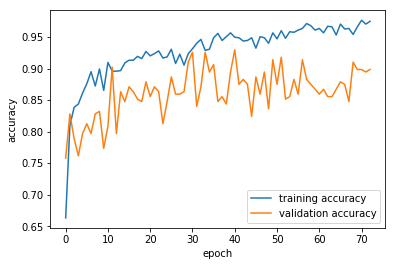

In [8]:
# plot training loss history
    
plt.plot(history_object.history['acc'])
plt.plot(history_object.history['val_acc'])
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['training accuracy','validation accuracy'],loc='lower right')
plt.show()

In [36]:
# set up sliding window for detection

def sliding_window(img, patch_size=[IM_SIZE,IM_SIZE],
                   istep=int(IM_SIZE/2), jstep=int(IM_SIZE/2), scale=1.0):
    Ni, Nj = (int(scale * s) for s in patch_size)
    for i in range(0, img.shape[0] - Ni, istep):
        for j in range(0, img.shape[1] - Ni, jstep):
            patch = img[i:i + Ni, j:j + Nj]
            if scale != 1:
                patch = transform.resize(patch, patch_size)
            yield (i, j), patch

In [11]:
def make_bbox(coords,box_side_meters=150):
    # define a bbox of specified side length centered on coords
    # should probably upgrade this with haversine function
    latitude,longitude = coords
    assert latitude >=-90 and latitude <= 90, u"Error with latitude"
    assert longitude >=-180 and longitude <= 180, u"Error with longitude"
    earth_circumference_meters = 40000000
    d_lat = 0.5 * 360 * box_side_meters / earth_circumference_meters
    #d_long = d_lat / np.cos(2 * np.pi * latitude / 360) 
    d_long = d_lat
    return [longitude-d_long,latitude-d_lat,longitude+d_long,latitude+d_lat]
    
def search_unordered(bbox, _type=None, count=100, cloud_cover=10):
    # search for available imagery in bbox
    aoi = box(*bbox).wkt
    if _type:
        query = "item_type:{} AND item_type:DigitalGlobeAcquisition".format(_type)
    else:
        query = "item_type:DigitalGlobeAcquisition"
    query += " AND attributes.cloudCover_int:<{}".format(cloud_cover)
    return gbdx.vectors.query(aoi, query, count=count)

def order(img_id):
    # order imagery
    order = gbdx.Task("Auto_Ordering", cat_id=img_id)
    order.impersonation_allowed = True
    wf = gbdx.Workflow([order])
    wf.execute()
    return wf

In [121]:
# get image for analysis

#test_latitude = 16.525157
#test_longitude = -94.935602
test_latitude = 16.541881
test_longitude = -95.002906
sensor_platform = u"WV02"

test_bbox = make_bbox((test_latitude,test_longitude),box_side_meters=2000)
records = search_unordered(test_bbox,_type=sensor_platform)
print(u"Found {0} records.".format(len(records)))
r = records[0]
test_cat_id = r['properties']['attributes']['catalogID']
test_date = r['properties']['item_date']
test_sensor = r['properties']['attributes']['sensorPlatformName']
print(u"{0},{1}: {2} ({3}) is from {4}.".format(test_latitude,test_longitude,test_cat_id,test_sensor,test_date))
wfs_test = order(test_cat_id)        
print(u"Ordered {0}.".format(test_cat_id))


Found 16 records.
16.541881,-95.002906: 1030010064B6F100 (WORLDVIEW02) is from 2017-01-12T17:07:55.741Z.
Ordered 1030010064B6F100.


In [124]:
print(wfs_test.status)

{u'state': u'running', u'event': u'started'}


In [125]:
# get test image
test_im = CatalogImage(test_cat_id, band_type="MS", bbox=test_bbox)
test_im_gray = color.rgb2gray(test_im.rgb())

Fetching Image... 16 tiles


Fetching Image... 16 tiles


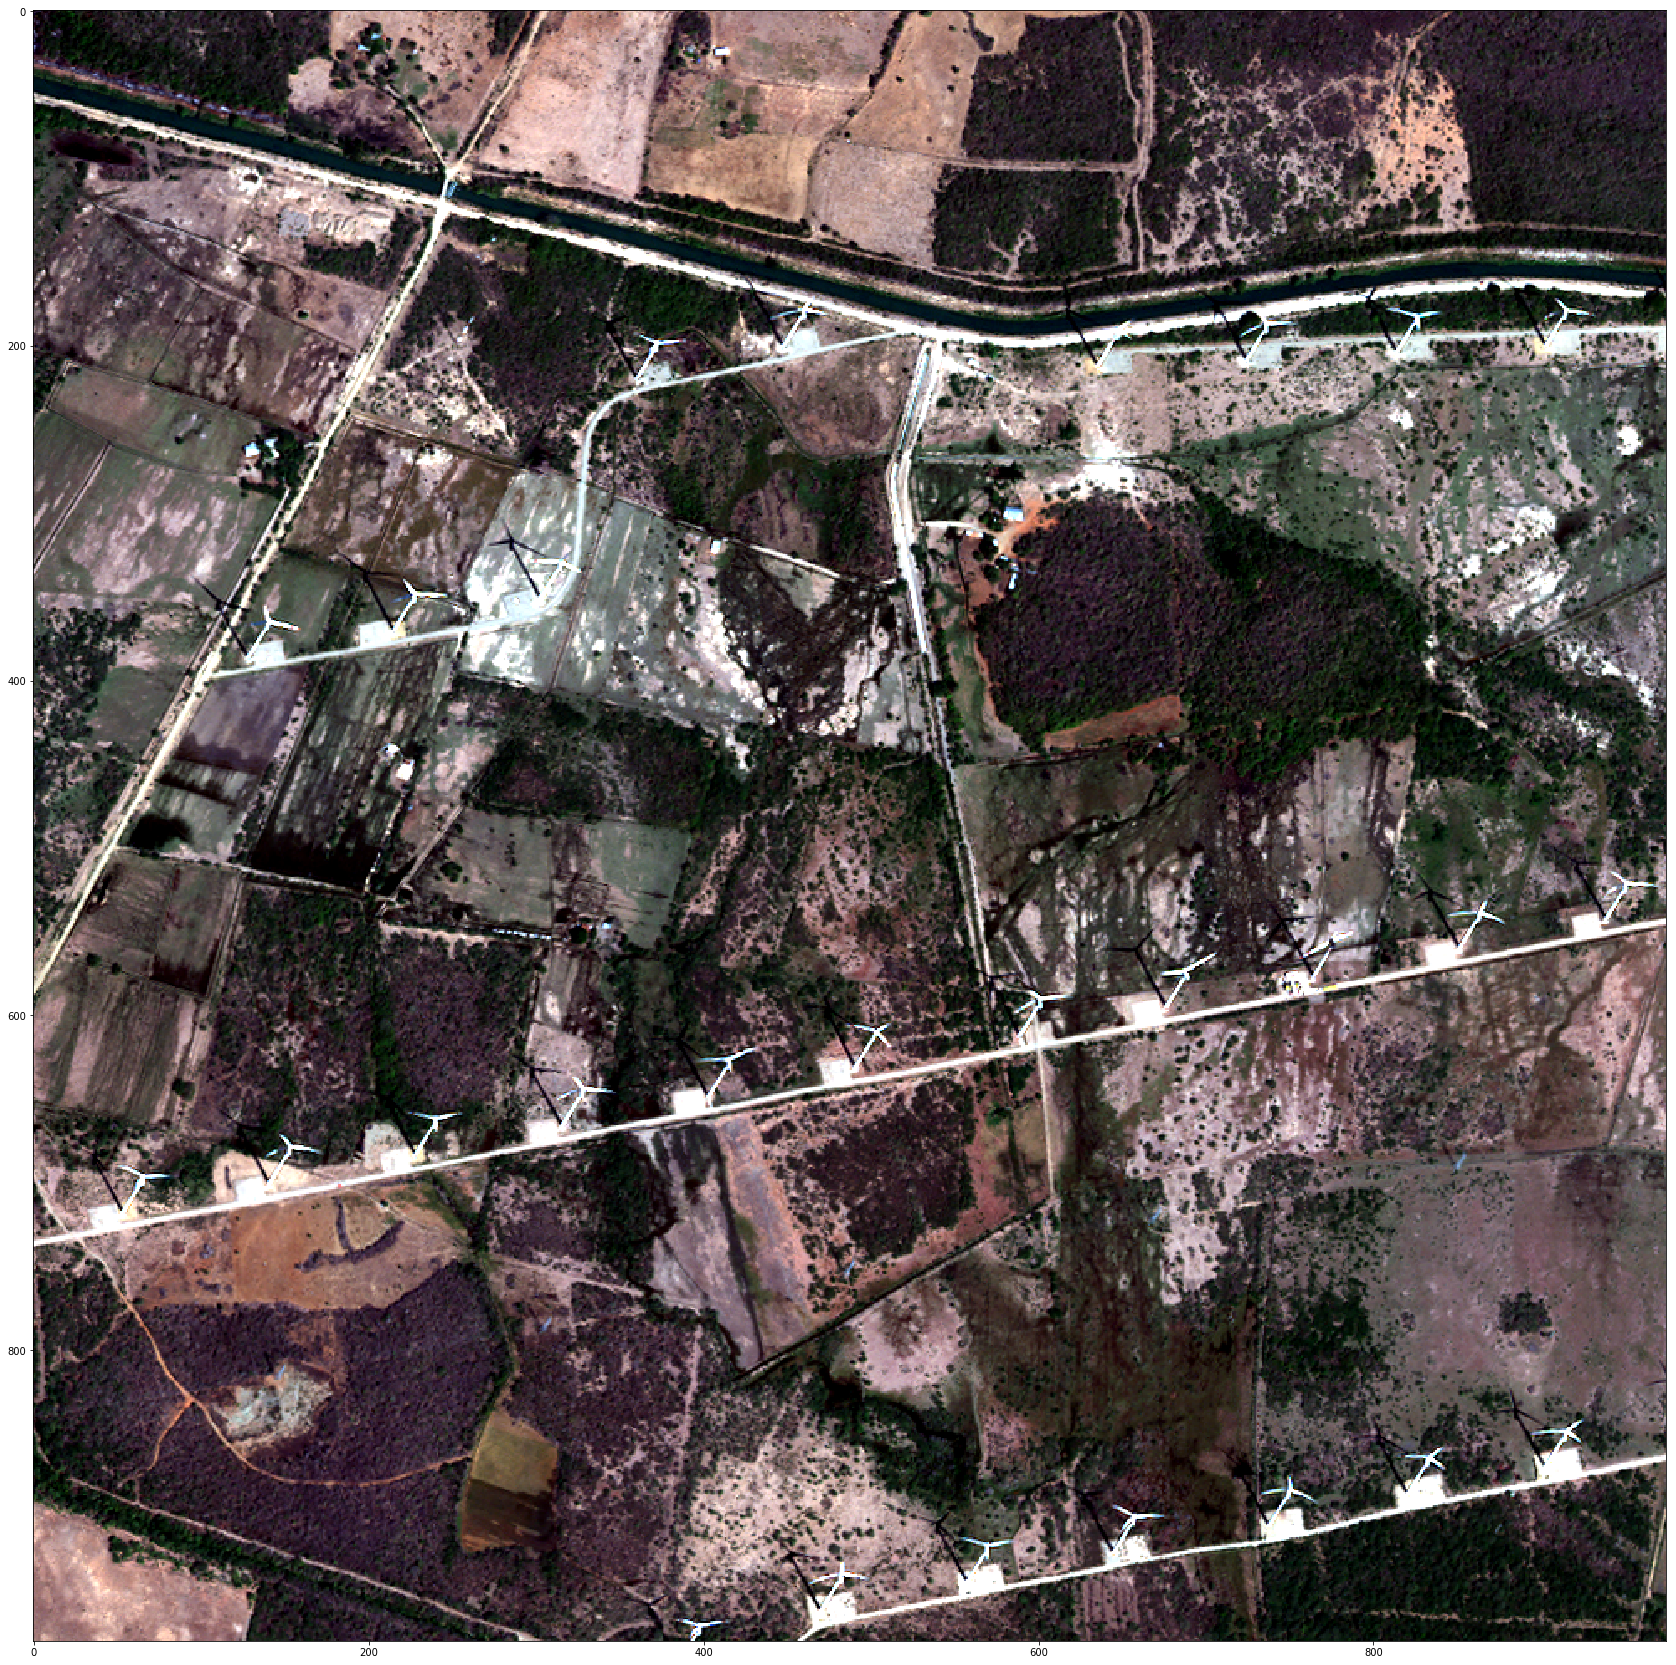

In [126]:
# show image
f = plt.figure(figsize=(30,30))
plt.imshow(test_im.rgb())
plt.show()

In [127]:
# do prediction using trained model and sliding windows

threshold = 0.95
hot_windows = []
istep = int(IM_SIZE/4)
jstep = int(IM_SIZE/4)
scale = 0.5
for win in sliding_window(test_im_gray,istep=istep,jstep=jstep,scale=scale):
    coords = win[0]
    patch = win[1]
    patch1 = np.expand_dims(patch,2)
    patch_for_prediction = np.expand_dims(patch1,0)
    prediction = model.predict(patch_for_prediction)
    if prediction[0] > threshold:
        hot_windows.append(coords)
print(u"Detected {0} turbines.".format(len(hot_windows)))

Detected 43 turbines.


Fetching Image... 16 tiles


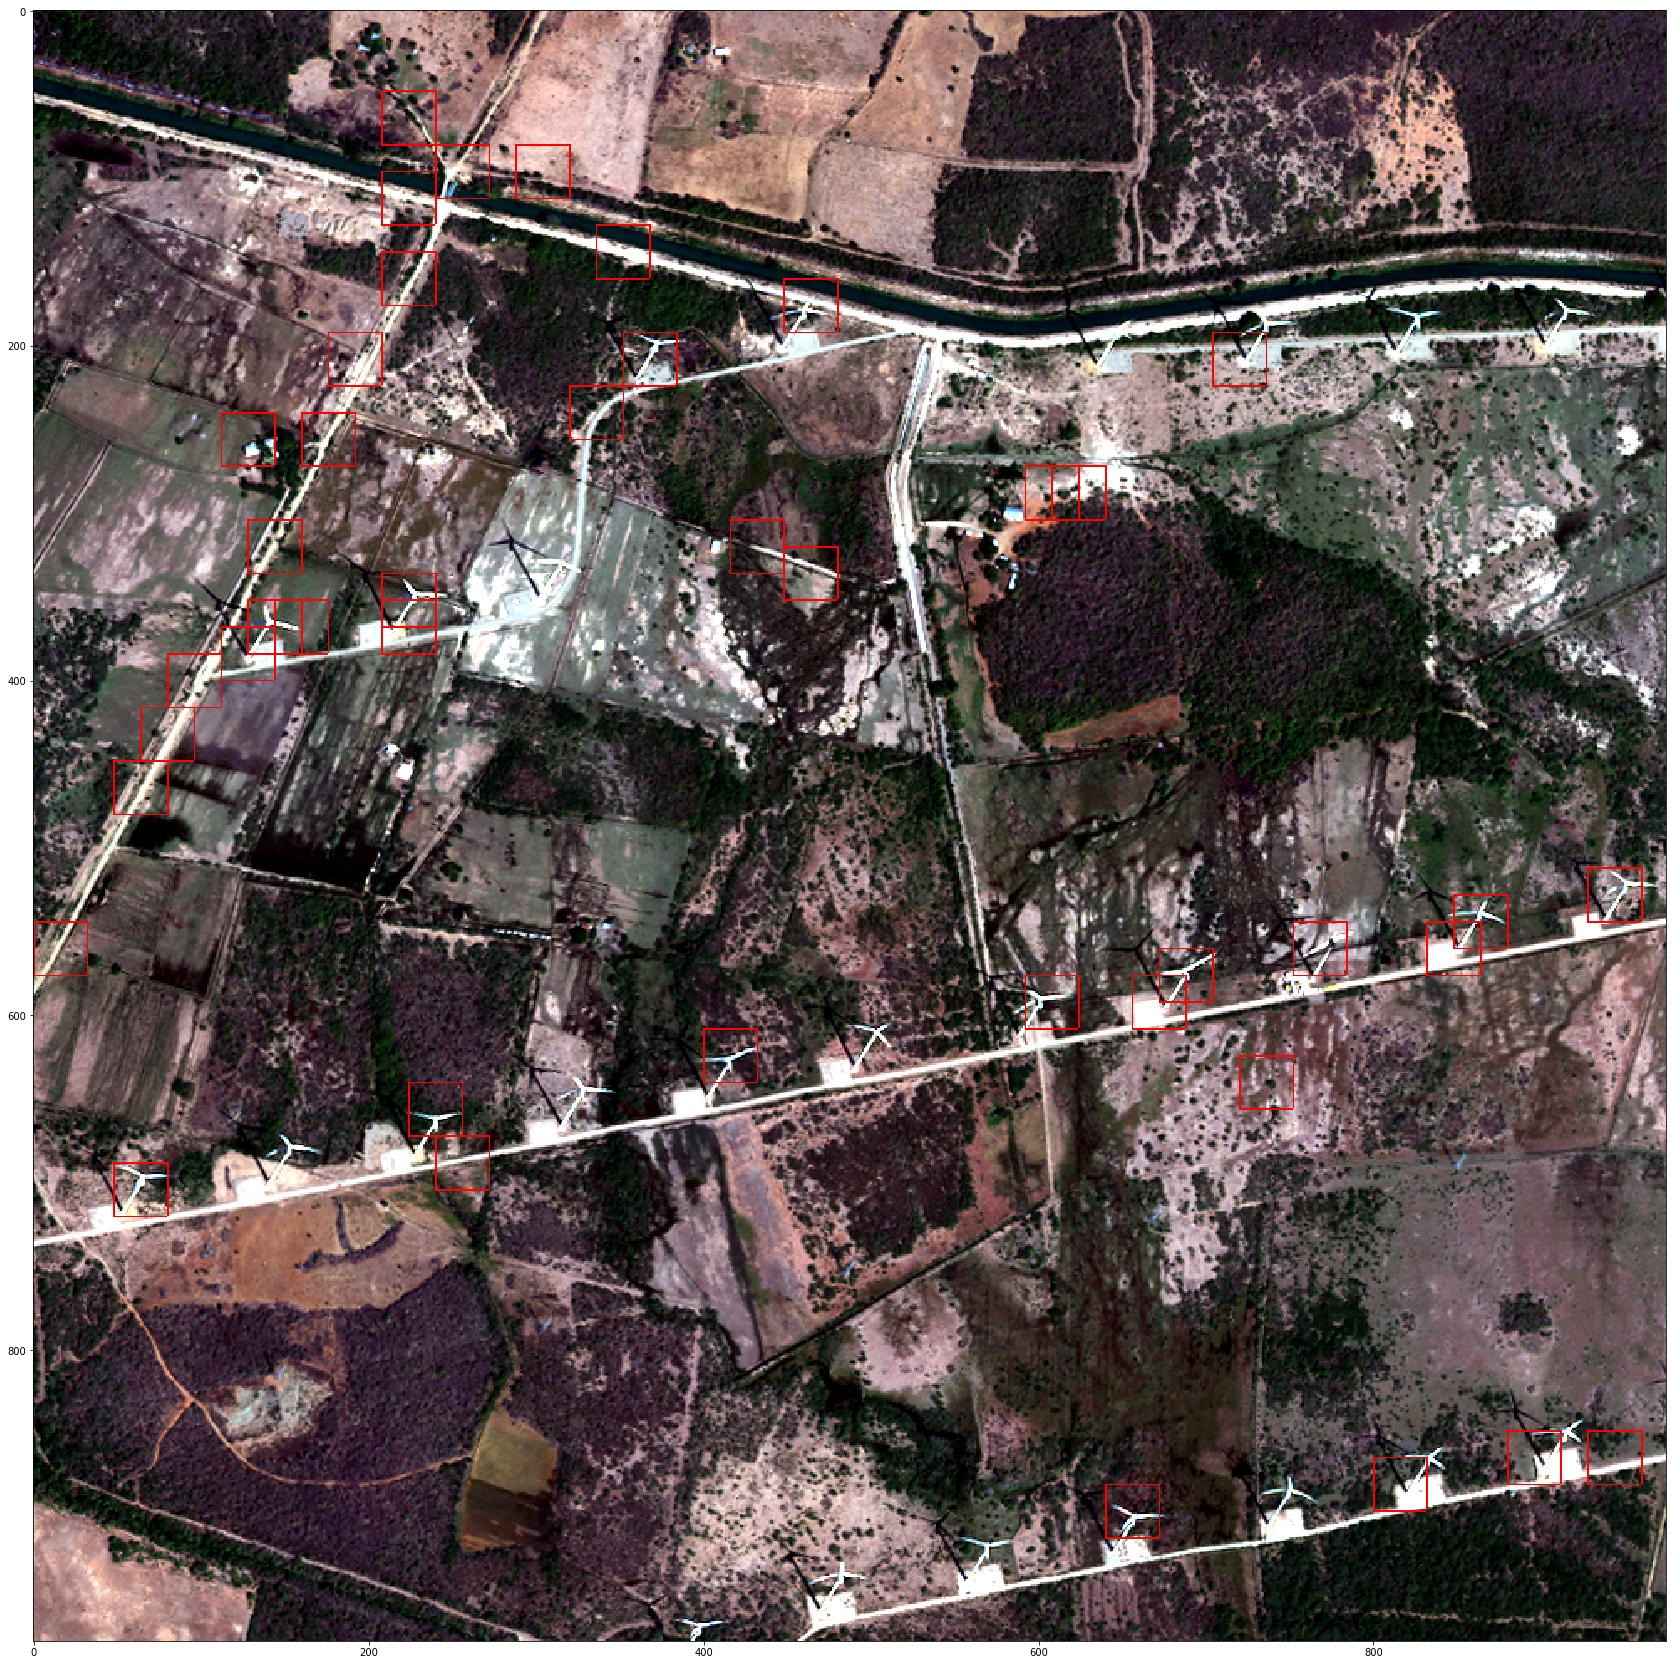

In [128]:
# display hot windows

test_im_boxes = test_im.rgb()
step = int(IM_SIZE * scale)
for hw in hot_windows:
    test_im_boxes[hw[0]:hw[0]+step,hw[1],:] = (255,0,0)
    test_im_boxes[hw[0]:hw[0]+step,hw[1]+step,:] = (255,0,0)
    test_im_boxes[hw[0],hw[1]:hw[1]+step,:] = (255,0,0)
    test_im_boxes[hw[0]+step,hw[1]:hw[1]+step,:] = (255,0,0)
f = plt.figure(figsize=(30,30))
plt.imshow(test_im_boxes)
plt.show()
